In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import gensim
import nltk  

from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
from collections import defaultdict,Counter
from matplotlib.legend_handler import HandlerLine2D

from google.colab import drive

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [262]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [ ]:
df = df.drop('id',axis=1)

In [ ]:
df.shape

(287113, 2)

In [ ]:
df['highlights']

0         Bishop John Folda, of North Dakota, is taking ...
1         Criminal complaint: Cop used his role to help ...
2         Craig Eccleston-Todd, 27, had drunk at least t...
3         Nina dos Santos says Europe must be ready to a...
4         Fleetwood top of League One after 2-0 win at S...
                                ...                        
287108    Chelsea Clinton said question of running for o...
287109    Vanilla Ice, 47 - real name Robert Van Winkle ...
287110    America's most lethal sniper made comment in i...
287111    A swarm of more than one million has crossed b...
287112    Other 2016 hopefuls maintain that Bush's annou...
Name: highlights, Length: 287113, dtype: object

## Analyzing text statistics
 - word frequency analysis,
 - sentence length analysis,
 - average word length analysis,

#### Checking average of character each sentence have

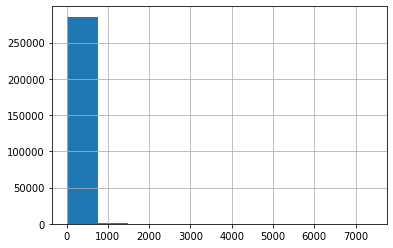

In [ ]:
df['highlights'].str.len().hist()

#### the number of words appearing in each news highlights.

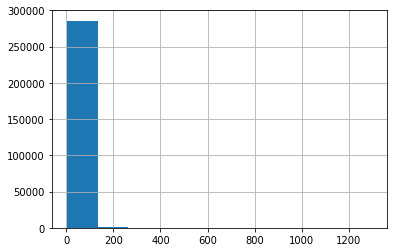

In [ ]:
df['highlights'].str.split().map(lambda x: len(x)).hist()

#### The average word length ranges

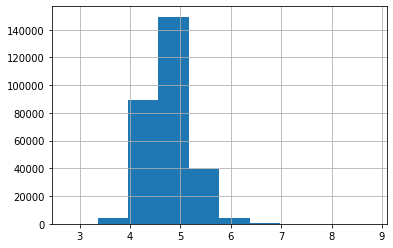

In [ ]:
df['highlights'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

#### Normalisation of text

In [ ]:
df['highlights'] = df['highlights'].apply(lambda value:value.lower())

In [ ]:
df['highlights'] = df['highlights'].apply(lambda value:re.sub('[,\.!?]', '', value))

In [ ]:
df['highlights'].head()

0    bishop john folda of north dakota is taking ti...
1    criminal complaint: cop used his role to help ...
2    craig eccleston-todd 27 had drunk at least thr...
3    nina dos santos says europe must be ready to a...
4    fleetwood top of league one after 2-0 win at s...
Name: highlights, dtype: object

#### Tokenize words and further clean-up text

In [ ]:
df['highlights'] = df['highlights'].apply(lambda value : gensim.utils.simple_preprocess(value, deacc=True))

####  which stopwords occur frequently in our text, let’s inspect which words other than these stopwords occur frequently.

In [ ]:
stop=set(stopwords.words('english'))

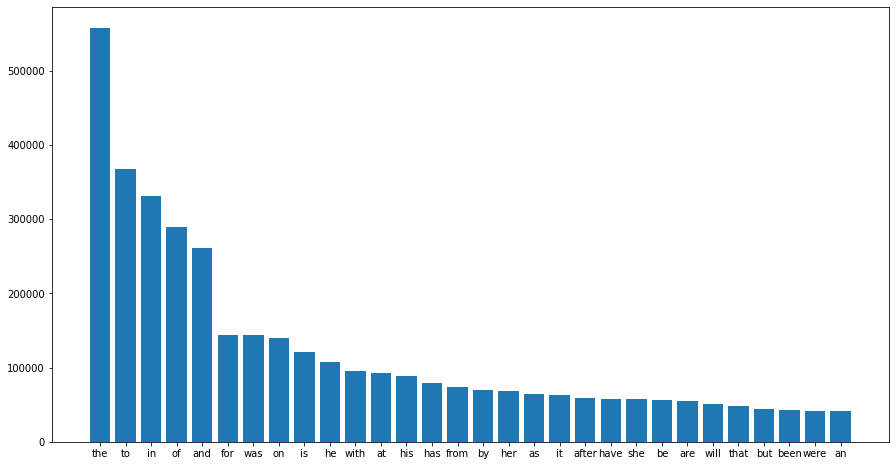

In [ ]:
def showstopwords(df):
  new= df
  new=new.values.tolist()
  corpus=[word for i in new for word in i]
  dic=defaultdict(int)
  for word in corpus:
    if word in stop:
      dic[word]+=1
              
              
  top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:30] 
  x,y=zip(*top)
  plt.figure(figsize=(15, 8))
  plt.bar(x,y)

showstopwords(df['highlights'])  

#### Removing stopwords

In [ ]:
df['highlights'] = df['highlights'].apply(lambda value: [word for word in value if word not in stop]) 

#### Top 50 most occuring words

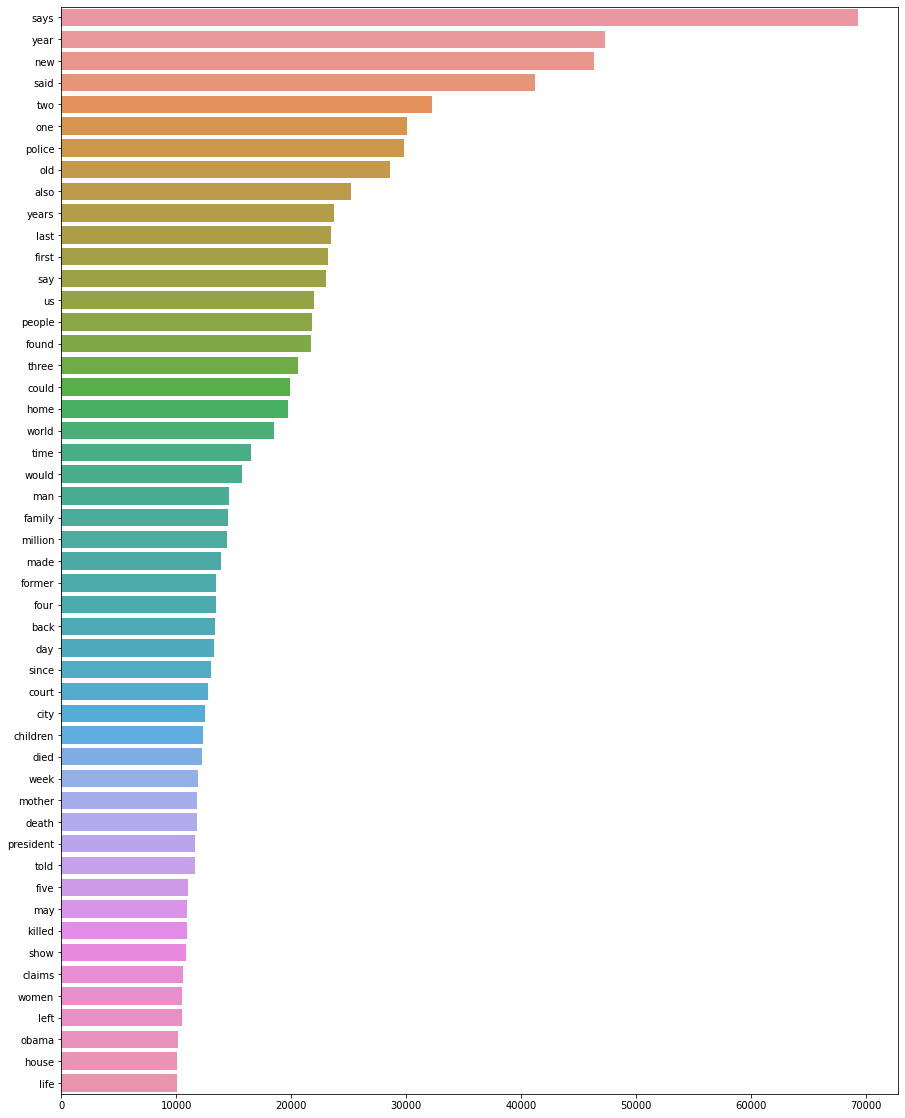

In [ ]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(15, 20))        
    sns.barplot(x=y,y=x)

plot_top_non_stopwords_barchart(df['highlights'])    

#### Bigram and trigram 

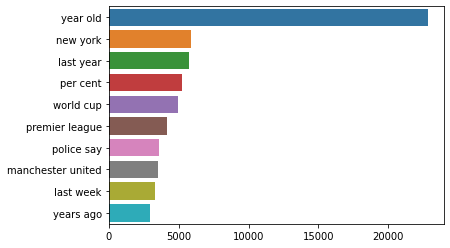

In [ ]:
def plot_top_ngrams_barchart(text, n=2):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
plot_top_ngrams_barchart(df['highlights'].apply(lambda value:' '.join(value)),2)    

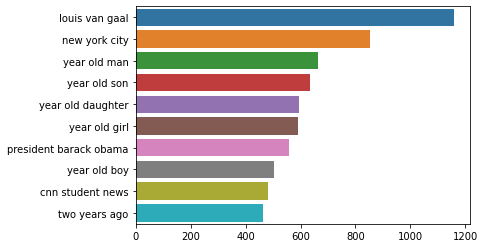

In [ ]:
plot_top_ngrams_barchart(df['highlights'].apply(lambda value:' '.join(value)),3)   

#### Applying bigram and trigram 

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df['highlights'], min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['highlights']], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
df['highlights_bigram'] = df['highlights'].apply(lambda value:bigram_mod[value])

In [ ]:
df['highlights_trigram'] = df['highlights'].apply(lambda value:trigram_mod[bigram_mod[value]])

#### Stemming and lemmatisation

In [ ]:
def applylemmachunk(feature,chunk):
  previousChunk = 0
  baseChunk = chunk
  currentChunk = chunk
  while(currentChunk<=df[feature].shape[0]):
    print(previousChunk,currentChunk)
    df[feature].iloc[previousChunk:currentChunk] = df[feature].iloc[previousChunk:currentChunk].apply(lambda value:[token.lemma_ for token in nlp(' '.join(value)) if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])
    previousChunk = currentChunk
    currentChunk = currentChunk + baseChunk

applylemmachunk('highlights',500)  

In [ ]:
applylemmachunk('highlights_bigram',500)   

In [ ]:
applylemmachunk('highlights_trigram',500) 

#### Sentiment Predictor using flair library

In [ ]:
! pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.9/401.9 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 54.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 KB 52.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence

In [ ]:
classifier = TextClassifier.load('en-sentiment')

2023-01-16 05:28:42,826 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpkh81fkm2


100%|██████████| 265512723/265512723 [00:16<00:00, 16297862.48B/s]

2023-01-16 05:28:59,636 copying /tmp/tmpkh81fkm2 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2023-01-16 05:29:00,229 removing temp file /tmp/tmpkh81fkm2
2023-01-16 05:29:00,310 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# print sentence with predicted labels
print('Sentence above is: ', )

Sentence above is: 


#### Predict the sentiment using flair library

In [ ]:
def predictsentiment(value):
  if len(value) != 0:
    sentence = Sentence(' '.join(value))
    classifier.predict(sentence)
    try:
      return str(sentence.labels[0].to_dict()['value'])
    except:
      return np.nan  
  else:
     return np.nan  

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/lemmatised_data.csv').drop('Unnamed: 0',axis=1)

In [ ]:
df['highlights_sentiment'] = np.zeros(df.shape[0])

In [ ]:
df.shape[0]

287113

In [ ]:
def applyflair(feature,chunk):
  previousChunk = 0
  baseChunk = chunk
  currentChunk = chunk
  while(currentChunk<30000):
    print(previousChunk,currentChunk)
    df['highlights_sentiment'].iloc[previousChunk:currentChunk] = df[feature].iloc[previousChunk:currentChunk].apply(predictsentiment)
    previousChunk = currentChunk
    currentChunk = currentChunk + baseChunk

applyflair('highlights',500) 

#### Creating Model that predict highlight sentiment

In [184]:
highlights = pd.read_csv('/content/sentiment_predict.csv')

In [185]:
test = highlights.loc[highlights['highlights_sentiment']=='0.0'].iloc[:,1:]

In [186]:
train = highlights.loc[highlights['highlights_sentiment']!='0.0'].iloc[:,1:]

In [ ]:
train.shape

(29500, 2)

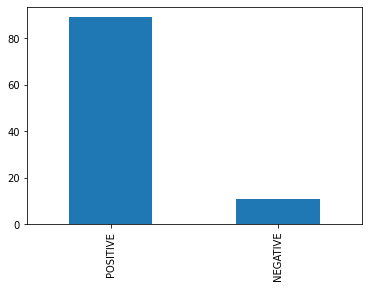

In [ ]:
(train['highlights_sentiment'].value_counts() / train.shape[0] *100).plot(kind='bar')

#### Note :
-  Working on imbalance dataset
-  lets work on data and fit various models to check which model works well    

In [187]:
train.isnull().sum()

highlights              0
highlights_sentiment    0
dtype: int64

In [188]:
train.duplicated().sum()

80

In [189]:
train = train.drop_duplicates(keep='first')

In [190]:
train.duplicated().sum()

0

In [191]:
train['highlights_sentiment'].value_counts()

POSITIVE    26201
NEGATIVE     3219
Name: highlights_sentiment, dtype: int64

#### Text Preprocessing
- Remove unnecessay tabs, spaces, emotes if any other noisy stuff
- tokenisation of sentences into words
- remove punctuations
- remove stopwords
- apply bigram and trigram
- vectorisation


In [192]:
train

,highlights,highlights_sentiment
0,"Bishop John Folda, of North Dakota, is taking ...",NEGATIVE
1,Criminal complaint: Cop used his role to help ...,POSITIVE
2,"Craig Eccleston-Todd, 27, had drunk at least t...",POSITIVE
3,Nina dos Santos says Europe must be ready to a...,POSITIVE
4,Fleetwood top of League One after 2-0 win at S...,POSITIVE
...,...,...
29495,A landmark statue has disappeared from a round...,POSITIVE
29496,Tropical storms Ingrid and Manuel bring chaos ...,POSITIVE
29497,Luke Skywalker's home planet of Tatooine is st...,NEGATIVE
29498,Nicholas Roker celebrated his 12th birthday on...,POSITIVE


In [193]:
def textpreprocessing(data,feature):
  # cleaning noisy and unnecessary stuff
  data[feature] = data[feature].apply(lambda value:value.lower())
  data[feature] = data[feature].apply(lambda value:re.sub('[,\.!?]', '', value))
  # tokenisation and remove punctuations
  data[feature] = data[feature].apply(lambda value : gensim.utils.simple_preprocess(value, deacc=True))
  # remove stopwords
  data[feature] = data[feature].apply(lambda value: [word for word in value if word not in stop]) 
  # bigram and trigram
  # Build the bigram and trigram models
  bigram = gensim.models.Phrases(data[feature], min_count=5, threshold=50) # higher threshold fewer phrases.
  trigram = gensim.models.Phrases(bigram[data[feature]], threshold=50)  

  # Faster way to get a sentence clubbed as a trigram/bigram
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)

  data[f'{feature}_bigram'] = data[feature].apply(lambda value:bigram_mod[value])
  data[f'{feature}_trigram'] = data[f'{feature}_bigram'].apply(lambda value:trigram_mod[value])

  data['highlights_trigram'] = data['highlights_trigram'].apply(lambda value: ' '.join(value))
  # vectorisation using spacy
  data['vectors'] = data['highlights_trigram'].apply(lambda value: nlp(value).vector)
  data = data.drop(['highlights','highlights_bigram','highlights_trigram'],axis=1)
  return data

In [194]:
data = textpreprocessing(train,'highlights')

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [195]:
data

,highlights_sentiment,vectors
0,NEGATIVE,"[0.52613026, 0.04160867, 0.059399456, -0.21926..."
1,POSITIVE,"[0.43310606, -0.04635367, -0.13228862, -0.3146..."
2,POSITIVE,"[0.27872035, -0.11107112, -0.0990278, -0.11224..."
3,POSITIVE,"[0.29787973, 0.025844362, -0.10898454, -0.3042..."
4,POSITIVE,"[0.50122494, 0.061790593, 0.00805073, -0.20833..."
...,...,...
29495,POSITIVE,"[0.44379663, 0.13821833, 0.058150504, -0.05946..."
29496,POSITIVE,"[0.29886225, -0.00628324, -0.24847665, 0.12519..."
29497,NEGATIVE,"[0.14478527, -0.03454891, -0.20462619, -0.1424..."
29498,POSITIVE,"[0.22425683, 0.30638742, 0.35982642, -0.091156..."


In [196]:
X = np.stack(data['vectors'])

In [197]:
y = data['highlights_sentiment']

In [198]:
! pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [199]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier 
from yellowbrick.classifier import ClassificationReport
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB,ComplementNB
from imblearn.metrics import (
    geometric_mean_score,
    make_index_balanced_accuracy,
)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve,auc,precision_score,recall_score,f1_score,precision_recall_fscore_support, roc_auc_score,plot_roc_curve,plot_precision_recall_curve  

## LogisticRegression

In [200]:
y = y.map({'NEGATIVE':0,'POSITIVE':1})

In [201]:
clf = LogisticRegression(random_state=0).fit(X[:28000], y[:28000])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [202]:
pred = clf.predict(X[28001:])

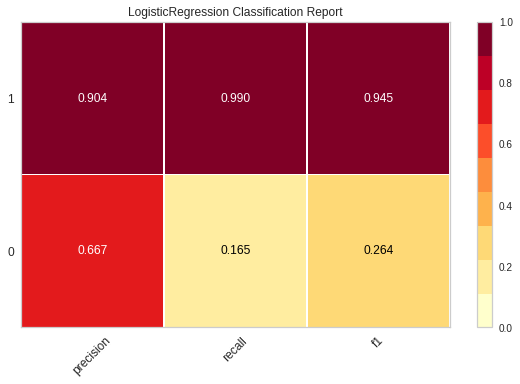

In [203]:
visualizer = ClassificationReport(clf)

visualizer.fit(X[:28000], y[:28000])        # Fit the visualizer and the model
visualizer.score(X[28001:], y[28001:])        # Evaluate the model on the test data
visualizer.show() 

In [ ]:
confusion_matrix(np.array(y[28001:]),pred)

array([[  27,  142],
       [  13, 1317]])

In [ ]:
print('precision test:', precision_score(np.array(y[28001:]),pred, pos_label=0))

precision test: 0.675


In [ ]:
print('Recall test:', recall_score(np.array(y[28001:]),pred, pos_label=0))

Recall test: 0.15976331360946747


In [ ]:
print('F-measure test:', f1_score(np.array(y[28001:]),pred, pos_label=0))

F-measure test: 0.2583732057416268


In [ ]:
print('G-Mean test:', geometric_mean_score(np.array(y[28001:]),pred))

G-Mean test: 0.39774579483764383


In [ ]:
def dominance(y_true, y_pred):
    tpr = recall_score(y_true, y_pred, pos_label=1)
    tnr = recall_score(y_true, y_pred, pos_label=0)
    print(tpr,tnr)
    return tpr - tnr

In [ ]:
print('Dominance test:', dominance(np.array(y[28001:]),pred))

0.9902255639097745 0.15976331360946747
Dominance test: 0.830462250300307


In [ ]:
print('ROC-AUC test:', roc_auc_score(np.array(y[28001:]),clf.predict_proba(X[28001:])[:,1]))

ROC-AUC test: 0.8038083374115763


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


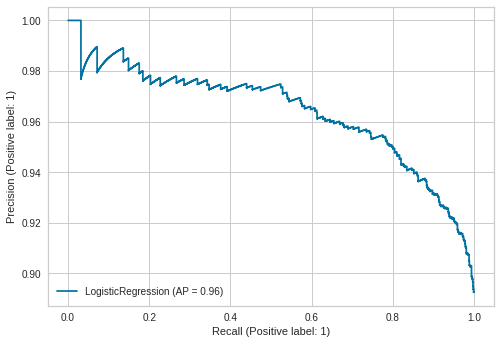

In [ ]:
rf_disp = plot_precision_recall_curve(clf,X[28001:],np.array(y[28001:]))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


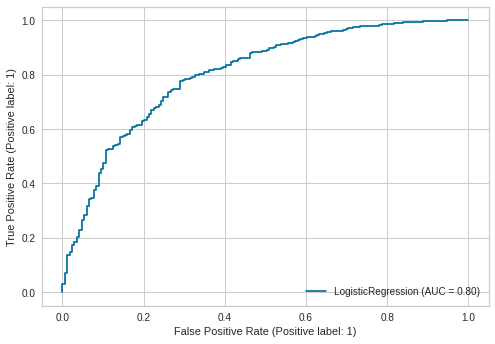

In [ ]:
rf_disp = plot_roc_curve(clf,X[28001:],np.array(y[28001:]))

In [ ]:
precision, recall, fscore, support = precision_recall_fscore_support(
   np.array(y[28001:]),pred, pos_label=0,
)

print('Precision: ', precision)
print('Recall: ', recall)
print('f-score: ', fscore)
print('Support: ', support)

Precision:  [0.675      0.90267306]
Recall:  [0.15976331 0.99022556]
f-score:  [0.25837321 0.94442452]
Support:  [ 169 1330]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [ ]:
print(classification_report(np.array(y[28001:]),pred))

              precision    recall  f1-score   support

           0       0.68      0.16      0.26       169
           1       0.90      0.99      0.94      1330

    accuracy                           0.90      1499
   macro avg       0.79      0.57      0.60      1499
weighted avg       0.88      0.90      0.87      1499



## Support Vector Machine Classifier

In [ ]:
svc = SVC(gamma='auto').fit(X[:28000], y[:28000])

In [ ]:
pred_svc = svc.predict(X[28001:])

In [ ]:
print(classification_report(np.array(y[28001:]),pred_svc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.89      1.00      0.94      1330

    accuracy                           0.89      1499
   macro avg       0.44      0.50      0.47      1499
weighted avg       0.79      0.89      0.83      1499



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##  Random Forest Classifier

In [ ]:
rf = RandomForestClassifier().fit(X[:28000], y[:28000])

In [ ]:
pred_rf = rf.predict(X[28001:])

In [ ]:
print(classification_report(np.array(y[28001:]),pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.10      0.18       169
           1       0.90      1.00      0.94      1330

    accuracy                           0.90      1499
   macro avg       0.83      0.55      0.56      1499
weighted avg       0.88      0.90      0.86      1499



## AdaBoost Classifier

In [ ]:
adc = AdaBoostClassifier(n_estimators=200, random_state=0).fit(X[:28000], y[:28000])

In [ ]:
pred_adc = adc.predict(X[28001:])

In [ ]:
print(classification_report(np.array(y[28001:]),pred_adc))

              precision    recall  f1-score   support

           0       0.52      0.20      0.28       169
           1       0.91      0.98      0.94      1330

    accuracy                           0.89      1499
   macro avg       0.71      0.59      0.61      1499
weighted avg       0.86      0.89      0.87      1499



## GradientBoosting Classifier

In [ ]:
dbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X[:28000], y[:28000])

In [ ]:
pred_dbc = dbc.predict(X[28001:])

In [ ]:
print(classification_report(np.array(y[28001:]),pred_dbc))

              precision    recall  f1-score   support

           0       0.52      0.21      0.30       169
           1       0.91      0.98      0.94      1330

    accuracy                           0.89      1499
   macro avg       0.71      0.59      0.62      1499
weighted avg       0.86      0.89      0.87      1499



## GaussianNB

In [ ]:
gnb = GaussianNB(var_smoothing=1.0).fit(X[:28000], y[:28000])

In [ ]:
pred_gnb = gnb.predict(X[28001:])

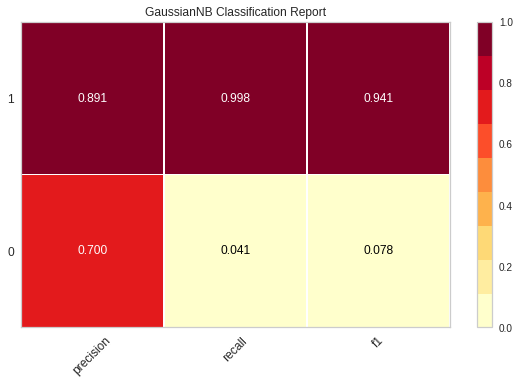

In [ ]:
visualizer = ClassificationReport(gnb)

visualizer.fit(X[:28000], y[:28000])        # Fit the visualizer and the model
visualizer.score(X[28001:], y[28001:])        # Evaluate the model on the test data
visualizer.show() 

In [ ]:
print('G-Mean test:', geometric_mean_score(np.array(y[28001:]),pred_gnb))

G-Mean test: 0.20328966895744396


In [ ]:
print('Dominance test:', dominance(np.array(y[28001:]),pred_gnb))

0.9977443609022556 0.04142011834319527
Dominance test: 0.9563242425590603


In [ ]:
print('ROC-AUC test:', roc_auc_score(np.array(y[28001:]),gnb.predict_proba(X[28001:])[:,1]))

ROC-AUC test: 0.7552564844062819


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


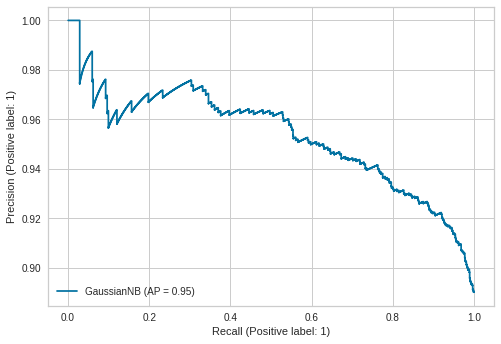

In [ ]:
rf_disp = plot_precision_recall_curve(gnb,X[28001:],np.array(y[28001:]))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


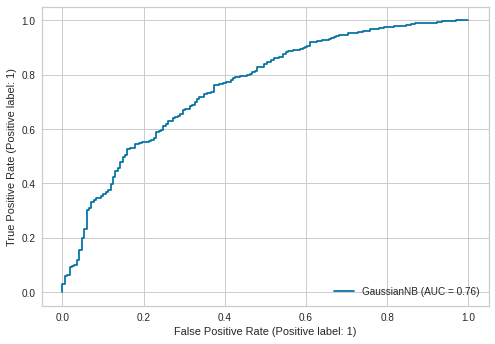

In [ ]:
rf_disp = plot_roc_curve(gnb,X[28001:],np.array(y[28001:]))

In [ ]:
confusion_matrix(np.array(y[28001:]),pred_gnb)

array([[   7,  162],
       [   3, 1327]])

In [ ]:
print(classification_report(np.array(y[28001:]),pred_gnb))

              precision    recall  f1-score   support

           0       0.70      0.04      0.08       169
           1       0.89      1.00      0.94      1330

    accuracy                           0.89      1499
   macro avg       0.80      0.52      0.51      1499
weighted avg       0.87      0.89      0.84      1499



## BernoulliNB

In [ ]:
bnb = BernoulliNB(alpha=1.0).fit(X[:28000], y[:28000])

In [ ]:
pred_bnb = bnb.predict(X[28001:])

In [ ]:
print(classification_report(np.array(y[28001:]),pred_bnb))

              precision    recall  f1-score   support

           0       0.35      0.38      0.37       169
           1       0.92      0.91      0.91      1330

    accuracy                           0.85      1499
   macro avg       0.64      0.65      0.64      1499
weighted avg       0.86      0.85      0.85      1499



In [ ]:
test = test.dropna()

In [ ]:
test = textpreprocessing(test,'highlights')

<ipython-input-91-9118dec6d161>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = data[feature].apply(lambda value:value.lower())
<ipython-input-91-9118dec6d161>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = data[feature].apply(lambda value:re.sub('[,\.!?]', '', value))
<ipython-input-91-9118dec6d161>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [ ]:
gnb.predict(np.stack(test['vectors']))

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,

## K mean

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=2).fit(X[:28000])

In [ ]:
pred_kmean = kmeans.predict(X[28001:])

In [ ]:
print(classification_report(np.array(y[28001:]),pred_kmean))

              precision    recall  f1-score   support

           0       0.08      0.42      0.14       169
           1       0.85      0.42      0.56      1330

    accuracy                           0.42      1499
   macro avg       0.47      0.42      0.35      1499
weighted avg       0.76      0.42      0.52      1499



## Evaluation
  - Logistic and GuassionNB gives better results on imbalanced data go we are going to work with only 2 of them

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y[28001:], pred_gnb)

In [ ]:
np.logspace(0,-9, num=100)

array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31012970e-02, 1.87381742e-02,
       1.51991108e-02, 1.23284674e-02, 1.00000000e-02, 8.11130831e-03,
       6.57933225e-03, 5.33669923e-03, 4.32876128e-03, 3.51119173e-03,
       2.84803587e-03, 2.31012970e-03, 1.87381742e-03, 1.51991108e-03,
       1.23284674e-03, 1.00000000e-03, 8.11130831e-04, 6.57933225e-04,
       5.33669923e-04, 4.32876128e-04, 3.51119173e-04, 2.84803587e-04,
       2.31012970e-04, 1.87381742e-04, 1.51991108e-04, 1.23284674e-04,
       1.00000000e-04, 8.11130831e-05, 6.57933225e-05, 5.33669923e-05,
       4.32876128e-05, 3.51119173e-05, 2.84803587e-05, 2.31012970e-05,
       1.87381742e-05, 1.51991108e-05, 1.23284674e-05, 1.00000000e-05,
      

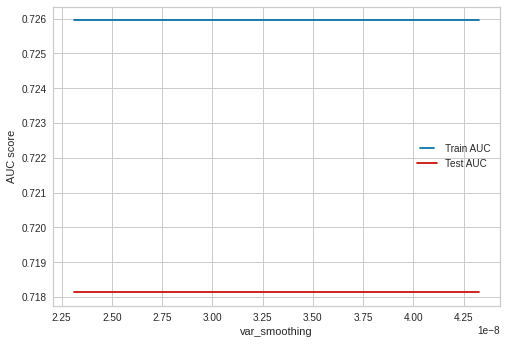

In [ ]:
var_smoothings = [4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08]
train_results = []
test_results = []
for var_smoothing in var_smoothings:
   gnb = GaussianNB(var_smoothing=var_smoothing)
   gnb.fit(X[:28000], y[:28000])
   train_pred = gnb.predict(X[:28000])
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y[:28000], train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = gnb.predict(X[28001:])                   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(np.array(y[28001:]), y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
  #  # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(var_smoothings, train_results, 'b', label='Train AUC')
line2, = plt.plot(var_smoothings, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('var_smoothing')
plt.show()

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}

gs_NB = GridSearchCV(estimator=GaussianNB(), 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

In [ ]:
gs_NB.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             scoring='accuracy', verbose=1)>

In [ ]:
gs_NB.fit(X[:28000], y[:28000])

Fitting 15 folds for each of 10 candidates, totalling 150 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             scoring='accuracy', verbose=1)

In [ ]:
gs_NB.best_score_

0.8935952380952382

In [ ]:
gs_NB.best_params_

{'var_smoothing': 1.0}

#  work on imbalance data

## Under Samplying Techniques

### Random Under samplying

In [257]:
from imblearn.under_sampling import RandomUnderSampler,InstanceHardnessThreshold,NearMiss
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN

from sklearn.model_selection import train_test_split

In [205]:
data

,highlights_sentiment,vectors
0,NEGATIVE,"[0.52613026, 0.04160867, 0.059399456, -0.21926..."
1,POSITIVE,"[0.43310606, -0.04635367, -0.13228862, -0.3146..."
2,POSITIVE,"[0.27872035, -0.11107112, -0.0990278, -0.11224..."
3,POSITIVE,"[0.29787973, 0.025844362, -0.10898454, -0.3042..."
4,POSITIVE,"[0.50122494, 0.061790593, 0.00805073, -0.20833..."
...,...,...
29495,POSITIVE,"[0.44379663, 0.13821833, 0.058150504, -0.05946..."
29496,POSITIVE,"[0.29886225, -0.00628324, -0.24847665, 0.12519..."
29497,NEGATIVE,"[0.14478527, -0.03454891, -0.20462619, -0.1424..."
29498,POSITIVE,"[0.22425683, 0.30638742, 0.35982642, -0.091156..."


In [206]:
y = data['highlights_sentiment'].map({'POSITIVE':1,'NEGATIVE':0})
X = np.stack(data['vectors'])

In [207]:
rus = RandomUnderSampler(
    sampling_strategy= 0.5,  # remember balancing ratio = x min / x maj
    random_state=0,  
    replacement=False # if it should resample with replacement
)  

In [208]:
X_resampled, y_resampled = rus.fit_resample(X, y)

In [209]:
y_resampled.value_counts()

1    6438
0    3219
Name: highlights_sentiment, dtype: int64

#### Logistic regression for random samplying data set

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

In [211]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [212]:
pred = clf.predict(X_test)

In [240]:
def Result(y_test,pred,X_train,y_train,X_test,model):
  print(f'Accuracy Score : {accuracy_score(y_test,pred)} \n')

  print(f'Confusion Matrix {confusion_matrix(y_test,pred)} \n')

  visualizer = ClassificationReport(clf)

  visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
  visualizer.score(X_train, y_train)        # Evaluate the model on the test data
  visualizer.show() 
  print('\n')
  print('ROC-AUC test:', roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))
  print('\n')
  rf_disp = plot_roc_curve(model,X_train,y_train)
  print('\n')
  rf_disp = plot_precision_recall_curve(model,X_train,y_train)
  print('\n')
  precision, recall, fscore, support = precision_recall_fscore_support(
   y_test,pred, pos_label=[0,1],
  )
  
  print('Precision: ', precision)
  print('Recall: ', recall)
  print('f-score: ', fscore)
  print('Support: ', support)
  print('\n')
  print('Dominance test:', dominance(y_test,pred))

Random samplying with equal amount of class (ratio 1:1 )

Accuracy Score : 0.7596485723250705 

Confusion Matrix [[ 546  551]
 [ 215 1875]] 



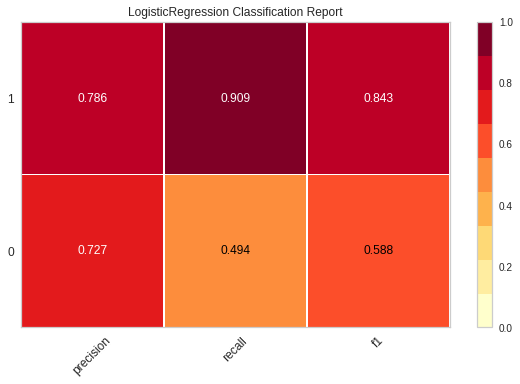



ROC-AUC test: 0.8071229494968879






Precision:  [0.717477   0.77287716]
Recall:  [0.49772106 0.89712919]
f-score:  [0.58772874 0.83038087]
Support:  [1097 2090]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

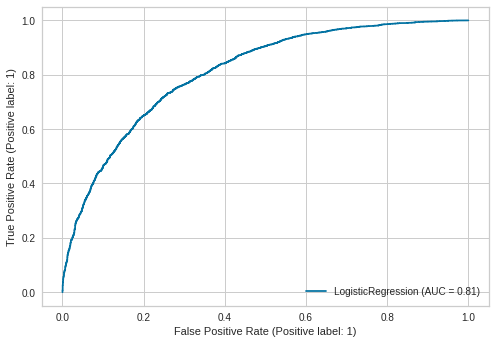

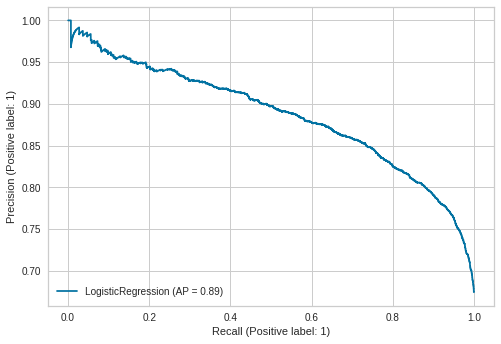

In [214]:
Result(y_test,pred,X_train,y_train,X_test,clf)

Ramdom samplying with unequal amount of classes (ratio 1:0.5)

Accuracy Score : 0.75125 

Confusion Matrix [[ 514  573]
 [ 223 1890]] 



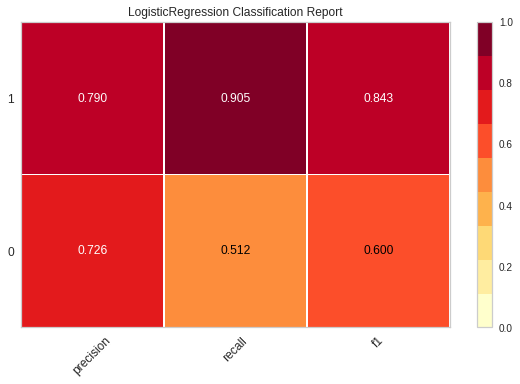



ROC-AUC test: 0.791164434823459






Precision:  [0.69742198 0.76735688]
Recall:  [0.47286109 0.89446285]
f-score:  [0.56359649 0.82604895]
Support:  [1087 2113]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

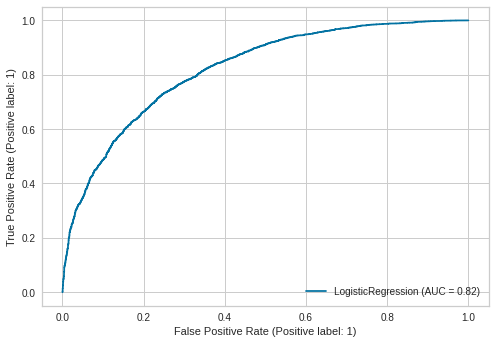

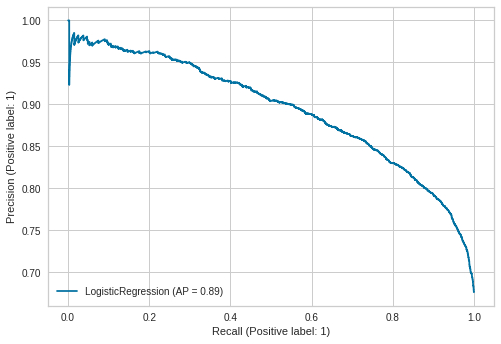

In [ ]:
Result(y_test,pred,X_train,y_train,X_test,clf)

### NearMiss

In [215]:
nm1 = NearMiss(
    sampling_strategy='auto',  # undersamples only the majority class
    version=1,
    n_neighbors=3,
    n_jobs=4)  # I have 4 cores in my laptop

X_resampled, y_resampled = nm1.fit_resample(X, y)

In [216]:
X_resampled.shape,X.shape,y_resampled.shape,y.shape

((6438, 96), (29420, 96), (6438,), (29420,))

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,test_size=0.33, random_state=42)

In [218]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [219]:
pred = clf.predict(X_test)

#### NearMiss result for version 1

Accuracy Score : 0.8131764705882353 

Confusion Matrix [[841 246]
 [151 887]] 



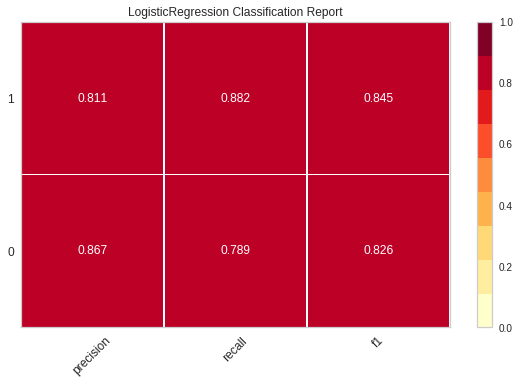



ROC-AUC test: 0.8877680345580012






Precision:  [0.84778226 0.78287732]
Recall:  [0.77368905 0.85452794]
f-score:  [0.80904281 0.81713496]
Support:  [1087 1038]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

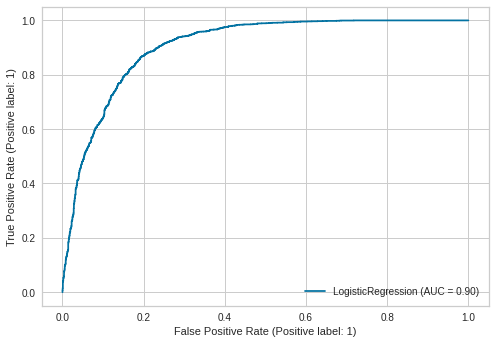

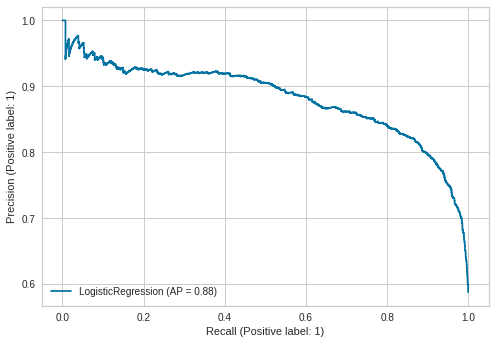

In [220]:
Result(y_test,pred,X_train,y_train,X_test,clf)

#### NearMiss for version 2

Accuracy Score : 0.753514526710403 

Confusion Matrix [[772 322]
 [204 836]] 



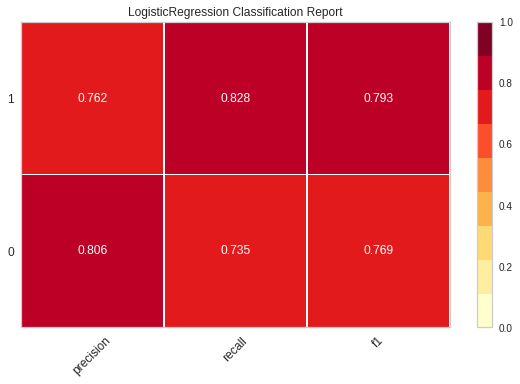



ROC-AUC test: 0.8212751371115175






Precision:  [0.79098361 0.72193437]
Recall:  [0.70566728 0.80384615]
f-score:  [0.74589372 0.76069154]
Support:  [1094 1040]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

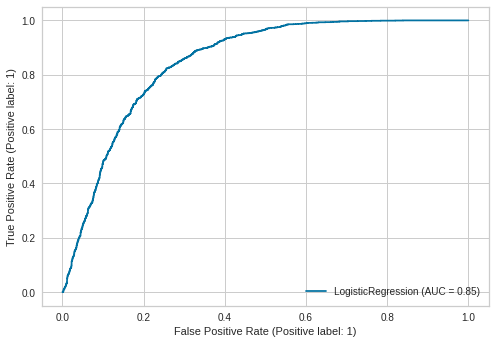

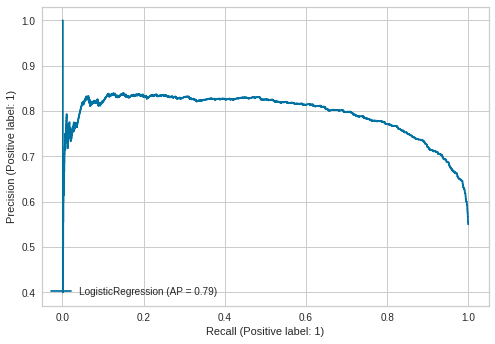

In [ ]:
Result(y_test,pred,X_train,y_train,X_test,clf)

#### NearMiss for version 3

Accuracy Score : 0.6902530459231491 

Confusion Matrix [[697 397]
 [264 776]] 



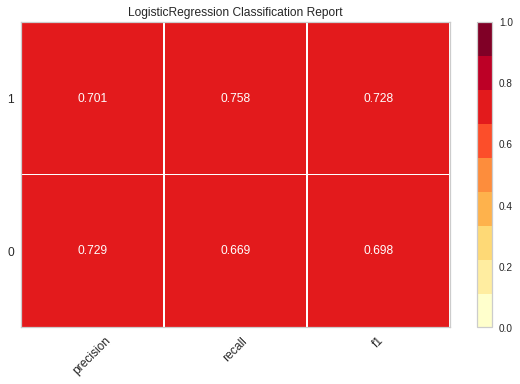



ROC-AUC test: 0.7681672760511883






Precision:  [0.72528616 0.66155158]
Recall:  [0.63711152 0.74615385]
f-score:  [0.6783455  0.70131044]
Support:  [1094 1040]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

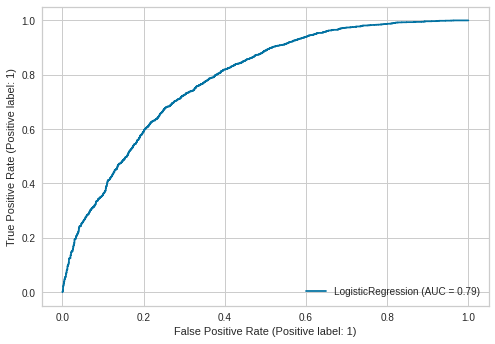

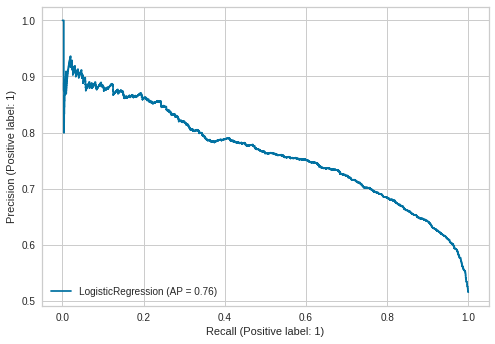

In [ ]:
Result(y_test,pred,X_train,y_train,X_test,clf)

### Instance Hardness

In [221]:
iht_logit = InstanceHardnessThreshold(
    estimator=clf,
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,
    n_jobs=4, # have 4 processors in my laptop
    cv=3)  # cross validation fold

X_logit, y_logit = iht_logit.fit_resample(X, y)

In [223]:
X_logit.shape,y_logit.shape

((4264, 96), (4264,))

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X_logit, y_logit,test_size=0.33, random_state=42)

In [225]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [226]:
pred = clf.predict(X_test)

Accuracy Score : 0.8188920454545454 

Confusion Matrix [[559 175]
 [ 80 594]] 



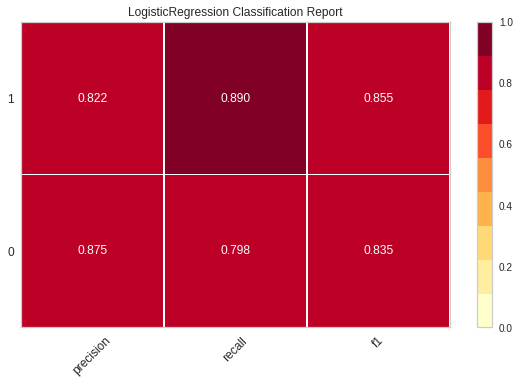



ROC-AUC test: 0.9011493462916099






Precision:  [0.87480438 0.77243173]
Recall:  [0.76158038 0.88130564]
f-score:  [0.81427531 0.82328482]
Support:  [734 674]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

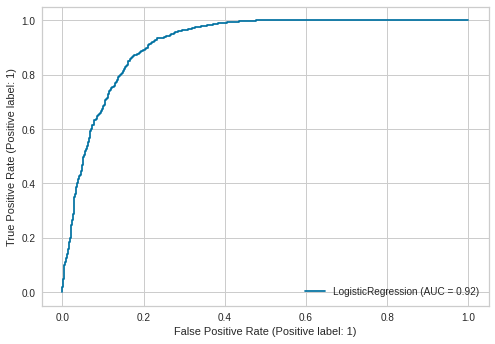

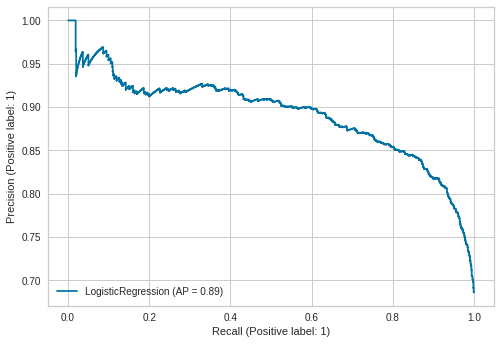

In [227]:
Result(y_test,pred,X_train,y_train,X_test,clf)

## Over Samplying Techniques

### Random Over Samplying 

In [230]:
ros = RandomOverSampler(
    sampling_strategy='not majority', # samples all but majority class
    random_state=0,  # for reproducibility
)

In [231]:
X_res, y_res = ros.fit_resample(X, y)

In [233]:
X_res.shape,y_res.shape

((52402, 96), (52402,))

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.33, random_state=42)

In [235]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35109, 96), (17293, 96), (35109,), (17293,))

In [236]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [237]:
pred = clf.predict(X_test)

Accuracy Score : 0.7354420863933383 

Confusion Matrix [[6220 2443]
 [2132 6498]] 



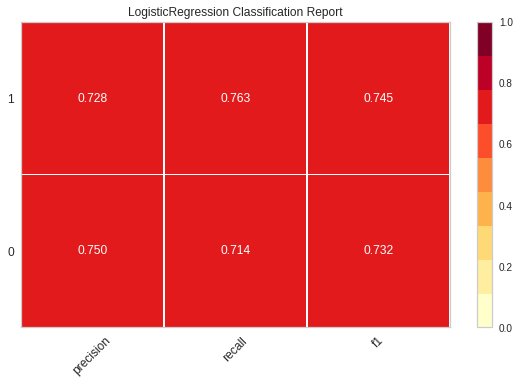



ROC-AUC test: 0.8109810117989575






Precision:  [0.7447318  0.72676434]
Recall:  [0.71799608 0.75295481]
f-score:  [0.7311196 0.7396278]
Support:  [8663 8630]




/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

0.752954808806489 0.7179960752626111
Dominance test: 0.03495873354387791


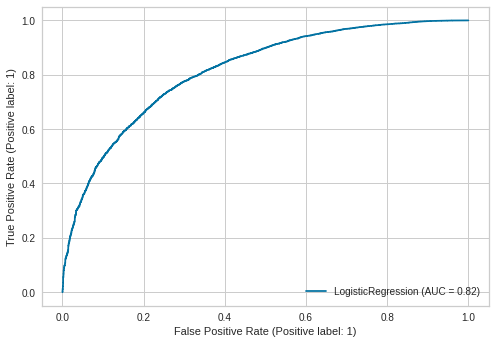

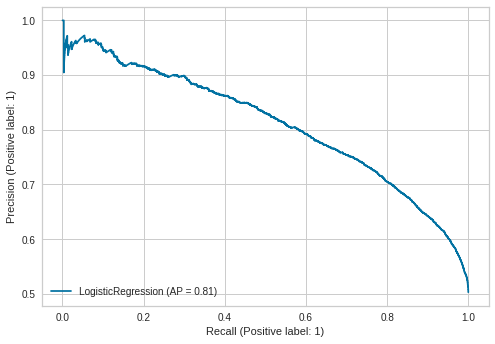

In [241]:
Result(y_test,pred,X_train,y_train,X_test,clf)

### Random Over Samplying with smoothing 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


result for 0.0
Accuracy Score : 0.7354420863933383 

Confusion Matrix [[6220 2443]
 [2132 6498]] 



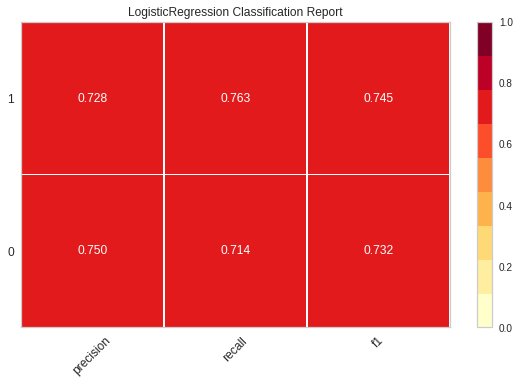



ROC-AUC test: 0.8109810117989575






Precision:  [0.7447318  0.72676434]
Recall:  [0.71799608 0.75295481]
f-score:  [0.7311196 0.7396278]
Support:  [8663 8630]


0.752954808806489 0.7179960752626111
Dominance test: 0.03495873354387791


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

result for 0.1111111111111111
Accuracy Score : 0.7345168565315445 

Confusion Matrix [[6196 2467]
 [2124 6506]] 



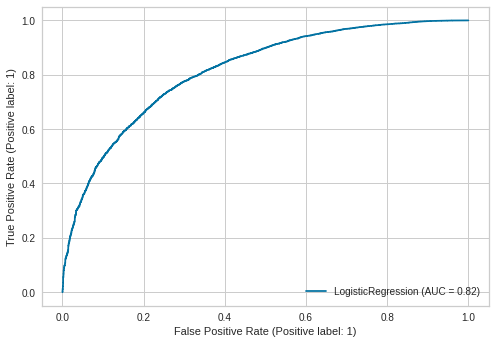

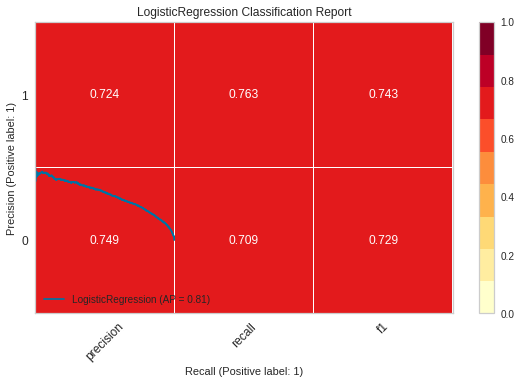



ROC-AUC test: 0.8097876599632781






Precision:  [0.74471154 0.72506408]
Recall:  [0.71522567 0.75388181]
f-score:  [0.72967085 0.73919218]
Support:  [8663 8630]


0.7538818076477405 0.7152256723998615
Dominance test: 0.03865613524787903


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

result for 0.2222222222222222
Accuracy Score : 0.7332446654715781 

Confusion Matrix [[6169 2494]
 [2119 6511]] 



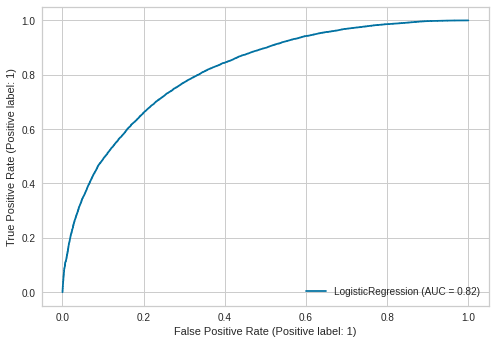

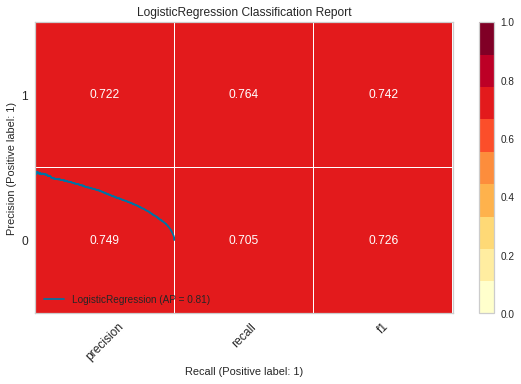



ROC-AUC test: 0.8066111266345103






Precision:  [0.74432915 0.72304275]
Recall:  [0.71210897 0.75446118]
f-score:  [0.72786266 0.73841792]
Support:  [8663 8630]


0.7544611819235226 0.7121089691792681
Dominance test: 0.04235221274425449


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

result for 0.3333333333333333
Accuracy Score : 0.7291389579598682 

Confusion Matrix [[6100 2563]
 [2121 6509]] 



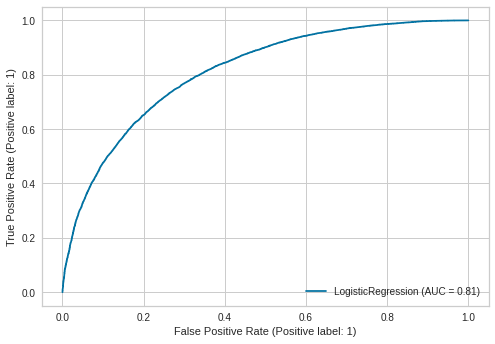

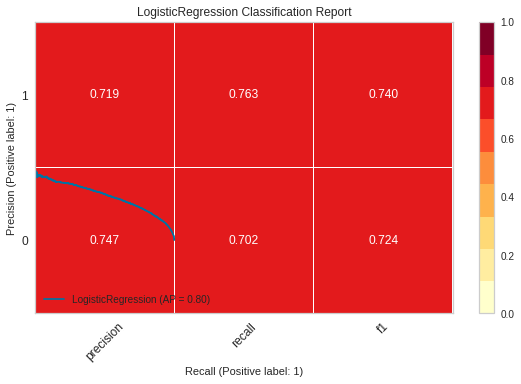



ROC-AUC test: 0.8020527893363567






Precision:  [0.74200219 0.71748236]
Recall:  [0.70414406 0.75422943]
f-score:  [0.72257759 0.73539713]
Support:  [8663 8630]


0.7542294322132097 0.704144060948863
Dominance test: 0.050085371264346756


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

result for 0.4444444444444444
Accuracy Score : 0.7261319609090383 

Confusion Matrix [[6055 2608]
 [2128 6502]] 



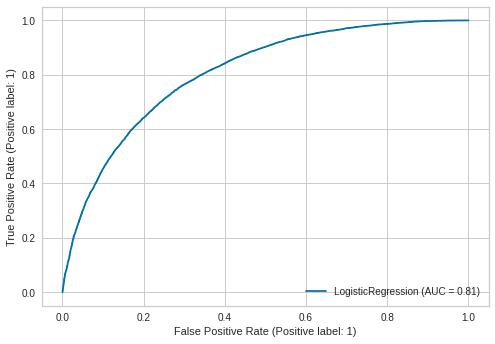

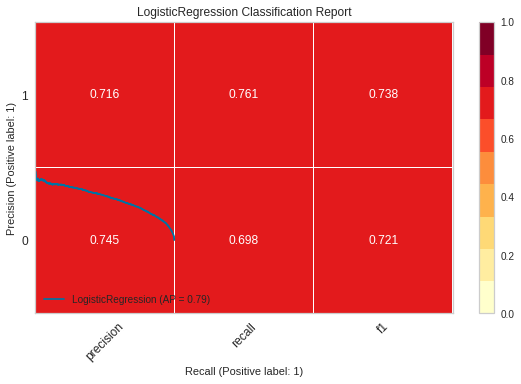



ROC-AUC test: 0.7966803318651572






Precision:  [0.73994867 0.71372119]
Recall:  [0.69894956 0.75341831]
f-score:  [0.71886501 0.73303269]
Support:  [8663 8630]


0.7534183082271148 0.6989495555812074
Dominance test: 0.05446875264590734


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

result for 0.5555555555555556
Accuracy Score : 0.7216792921991557 

Confusion Matrix [[5995 2668]
 [2145 6485]] 



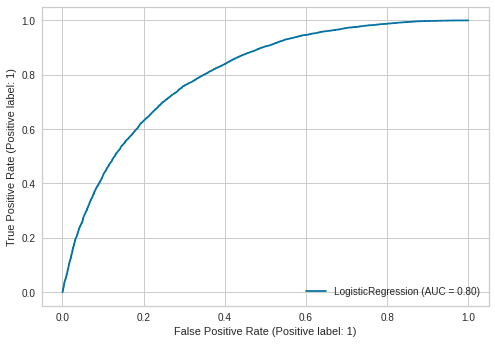

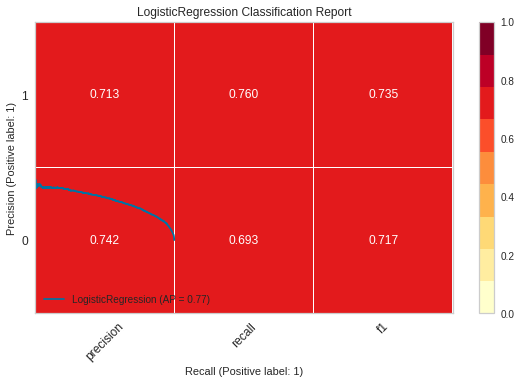



ROC-AUC test: 0.7909689039934757






Precision:  [0.73648649 0.70851087]
Recall:  [0.69202355 0.75144844]
f-score:  [0.71356305 0.72934825]
Support:  [8663 8630]


0.7514484356894554 0.6920235484243333
Dominance test: 0.05942488726512207


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

result for 0.6666666666666666
Accuracy Score : 0.7180361996183426 

Confusion Matrix [[5954 2709]
 [2167 6463]] 



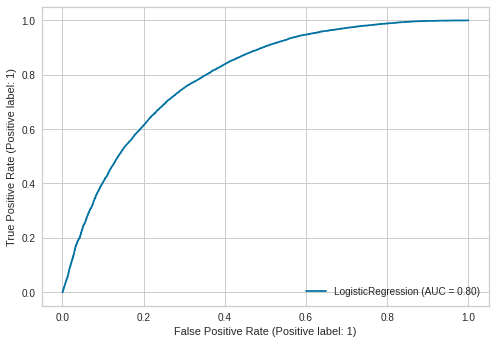

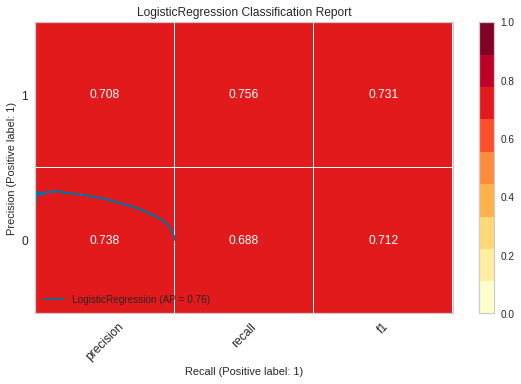



ROC-AUC test: 0.7851680185399768






Precision:  [0.73316094 0.70464457]
Recall:  [0.68729078 0.74889919]
f-score:  [0.70948522 0.72609819]
Support:  [8663 8630]


0.7488991888760139 0.6872907768671361
Dominance test: 0.06160841200887779


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

result for 0.7777777777777777
Accuracy Score : 0.7155496443647719 

Confusion Matrix [[5921 2742]
 [2177 6453]] 



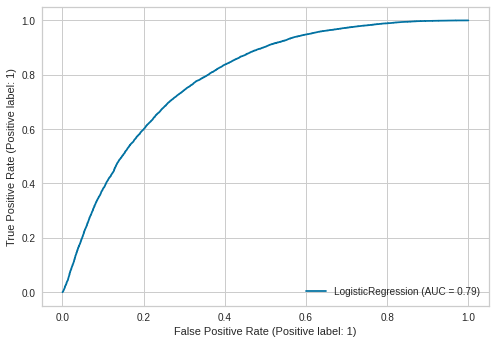

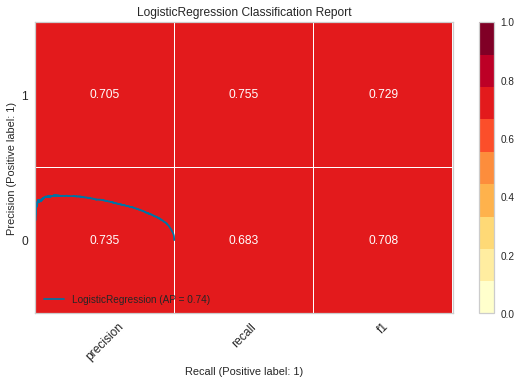



ROC-AUC test: 0.7794056822418006






Precision:  [0.73116819 0.70179445]
Recall:  [0.68348147 0.74774044]
f-score:  [0.70652109 0.72403927]
Support:  [8663 8630]


0.7477404403244496 0.6834814729308554
Dominance test: 0.06425896739359427


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

result for 0.8888888888888888
Accuracy Score : 0.7112704562539756 

Confusion Matrix [[5875 2788]
 [2205 6425]] 



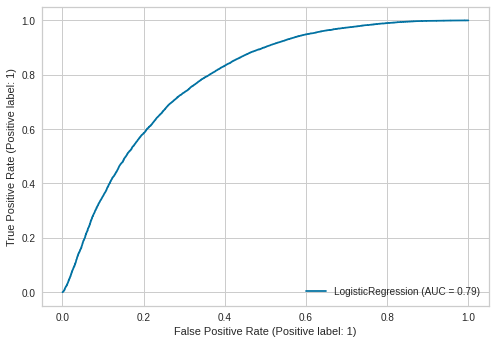

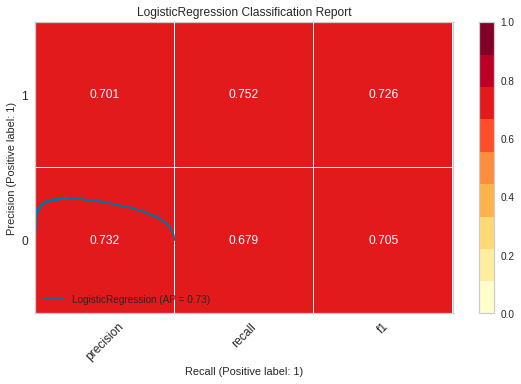



ROC-AUC test: 0.7737912960501563






Precision:  [0.72710396 0.69738413]
Recall:  [0.67817153 0.74449594]
f-score:  [0.70178582 0.72017037]
Support:  [8663 8630]


0.7444959443800695 0.6781715341105853
Dominance test: 0.06632441026948421


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

result for 1.0
Accuracy Score : 0.70837911293587 

Confusion Matrix [[5836 2827]
 [2216 6414]] 



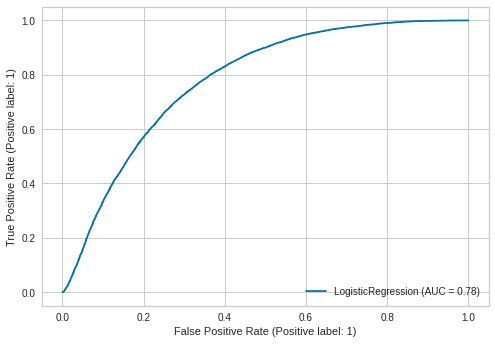

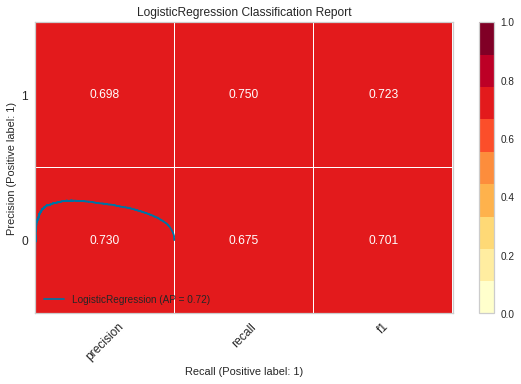



ROC-AUC test: 0.768349511628215






Precision:  [0.72478887 0.69408073]
Recall:  [0.67366963 0.74322132]
f-score:  [0.69829494 0.71781098]
Support:  [8663 8630]


0.7432213209733488 0.6736696294586171
Dominance test: 0.06955169151473173


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

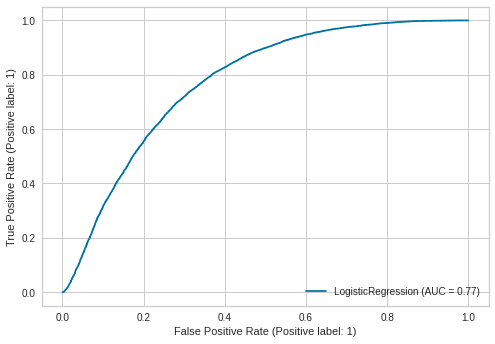

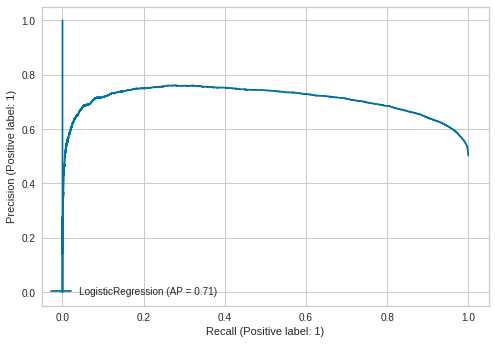

In [245]:
for shrink in np.linspace(0,1,10):
  ros = RandomOverSampler(
          sampling_strategy='auto', # samples only the minority class
          random_state=0,  # for reproducibility
          shrinkage = shrink,
  )

  X_res, y_res = ros.fit_resample(X, y)

  X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,test_size=0.33, random_state=42)

  clf = LogisticRegression(random_state=0).fit(X_train, y_train)

  pred = clf.predict(X_test)

  print(f'result for {shrink}')
  Result(y_test,pred,X_train,y_train,X_test,clf)

### SMOTE

In [252]:
sm = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=4
)

X_res, y_res = sm.fit_resample(X, y)

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.33, random_state=42)

In [254]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35109, 96), (17293, 96), (35109,), (17293,))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score : 0.7242236743190886 

Confusion Matrix [[6202 2461]
 [2308 6322]] 



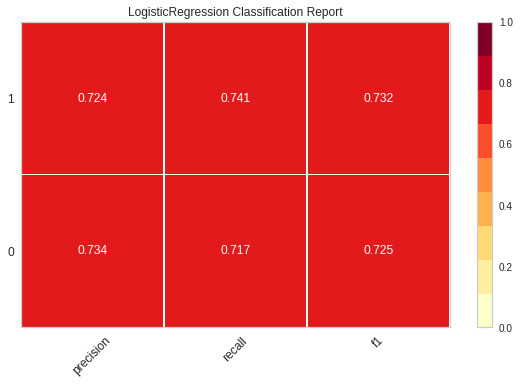



ROC-AUC test: 0.7972910055939078






/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)




Precision:  [0.72878966 0.71979961]
Recall:  [0.71591827 0.73256083]
f-score:  [0.72229663 0.72612416]
Support:  [8663 8630]


0.7325608342989571 0.7159182731155489
Dominance test: 0.016642561183408233


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


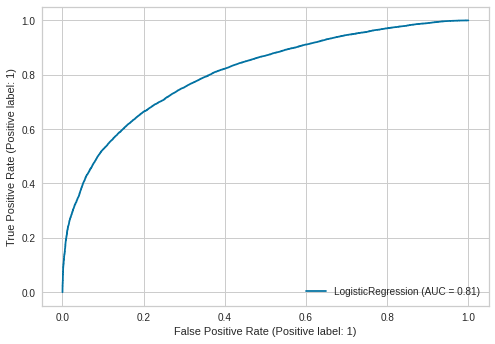

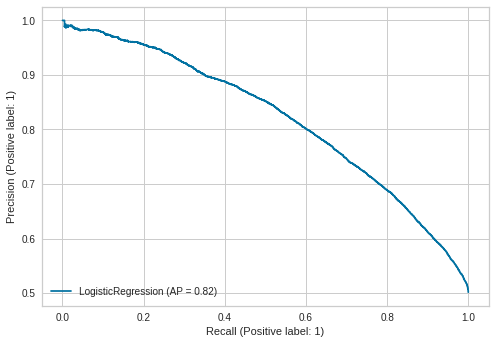

In [256]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

pred = clf.predict(X_test)

Result(y_test,pred,X_train,y_train,X_test,clf)

### ADASYN

In [258]:
ada = ADASYN(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    n_neighbors=5,
    n_jobs=4
)

X_res, y_res = ada.fit_resample(X, y)

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.33, random_state=42)

In [260]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35773, 96), (17621, 96), (35773,), (17621,))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score : 0.7144883945292548 

Confusion Matrix [[6414 2537]
 [2494 6176]] 



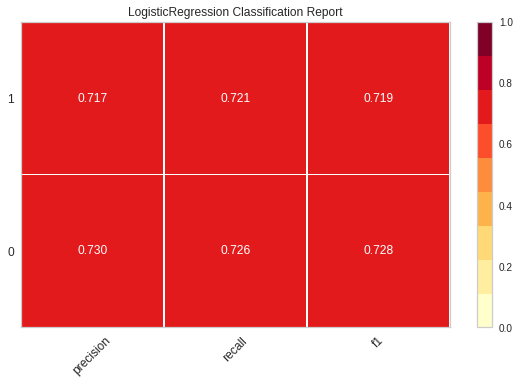



ROC-AUC test: 0.7921520692500256






/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)




Precision:  [0.72002694 0.70882589]
Recall:  [0.71656798 0.71234141]
f-score:  [0.7182933 0.7105793]
Support:  [8951 8670]


0.7123414071510957 0.7165679812311474
Dominance test: -0.0042265740800516705


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


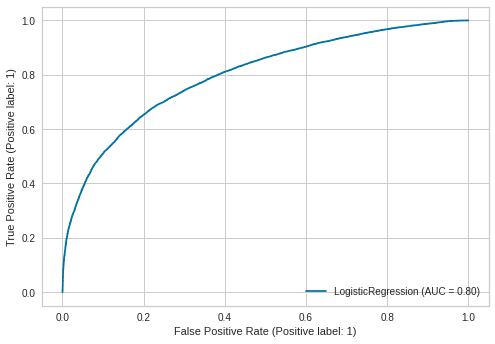

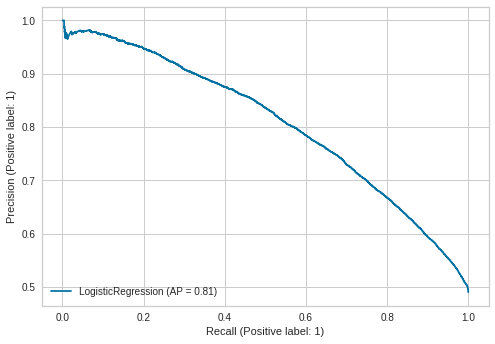

In [261]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

pred = clf.predict(X_test)

Result(y_test,pred,X_train,y_train,X_test,clf)

## Final Model

From the obove observation we got logistic regression is best performer for predicting sentiment for our dataset and NearMiss under sampling is giving best result for handling unbalance dataset 

In [268]:
nm1 = NearMiss(
    sampling_strategy='auto',  # undersamples only the majority class
    version=1,
    n_neighbors=3,
    n_jobs=4)  # I have 4 cores in my laptop

X_resampled, y_resampled = nm1.fit_resample(X, y)

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,test_size=0.33, random_state=42)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score : 0.8131764705882353 

Confusion Matrix [[841 246]
 [151 887]] 



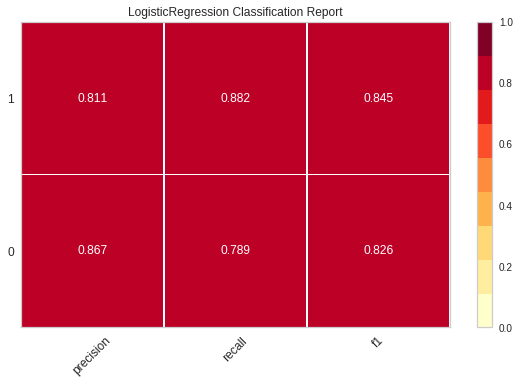



ROC-AUC test: 0.8877680345580012






Precision:  [0.84778226 0.78287732]
Recall:  [0.77368905 0.85452794]
f-score:  [0.80904281 0.81713496]
Support:  [1087 1038]




/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to [0, 1]) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a

0.8545279383429673 0.7736890524379025
Dominance test: 0.08083888590506472


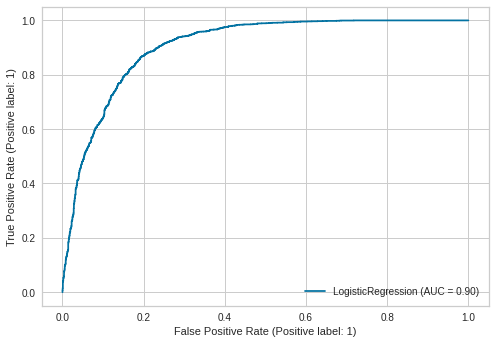

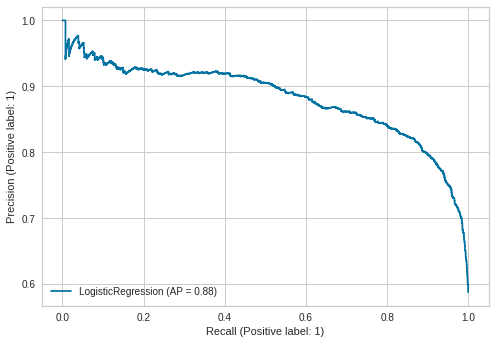

In [272]:
clf =  LogisticRegression(solver='lbfgs',penalty='l2',random_state=100).fit(X_train, y_train)

pred = clf.predict(X_test)

Result(y_test,pred,X_train,y_train,X_test,clf)

## Serialisation using pickle

In [277]:
import pickle

In [279]:
pick_insert = open('drive/My Drive/sentiment_model.pkl','wb')
pickle.dump(clf,pick_insert)